# Market Data Cleaning + Exploration

Importing dataset


In [107]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:

data = yf.download("SPY", start="2017-12-30", end="2020-07-19")

/tmp/ipython-input-1529075799.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2017-12-30", end="2020-07-19")
[*********************100%***********************]  1 of 1 completed


In [109]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700
2018-01-03,239.413971,239.564463,238.077344,238.077344,90070400
2018-01-04,240.423080,240.909944,239.475961,240.060181,80636400
2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000
2018-01-08,242.467789,242.627114,241.635720,241.927816,57319200


In [110]:
data.columns = data.columns.get_level_values(0)

In [111]:
data.shape

(640, 5)

In [112]:
print(list(data.columns))

['Close', 'High', 'Low', 'Open', 'Volume']


In [113]:
print(data.index)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
               '2020-07-10', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17'],
              dtype='datetime64[ns]', name='Date', length=640, freq=None)


Checking business days alignment to data shape

In [114]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Define the start and end dates from the data
start_date = data.index.min()
end_date = data.index.max()

# Create a custom business day calendar that includes US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Calculate the number of business days between the start and end dates
num_business_days = len(pd.date_range(start=start_date, end=end_date, freq=us_bd))

print(f"Number of rows in the data: {data.shape[0]}")
print(f"Number of business days between {start_date.date()} and {end_date.date()}: {num_business_days}")

print("\nDate range in the data:")
print(f"Start date: {start_date.date()}")
print(f"End date: {end_date.date()}")

Number of rows in the data: 640
Number of business days between 2018-01-02 and 2020-07-17: 640

Date range in the data:
Start date: 2018-01-02
End date: 2020-07-17


Checking for missing values

In [115]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


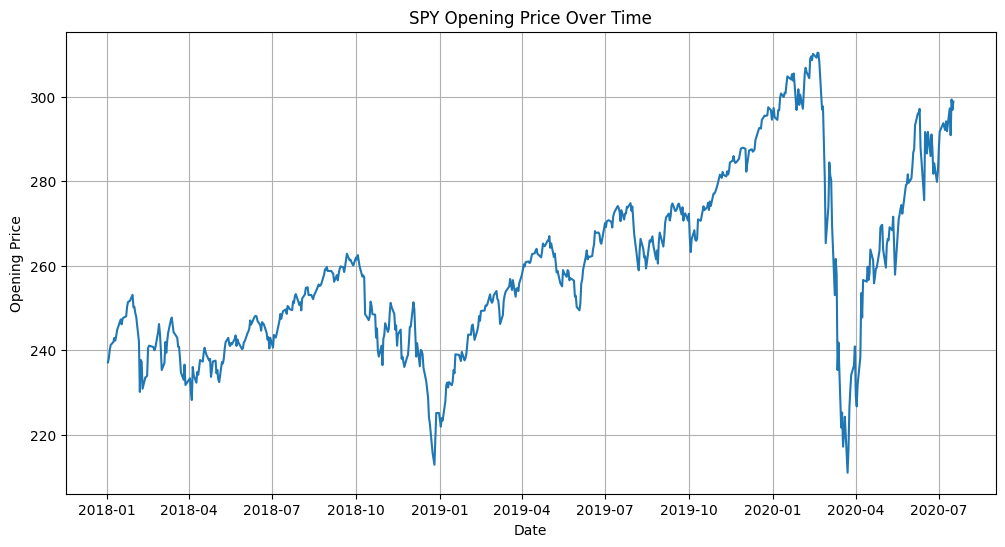

In [116]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data['Open'])
plt.title('SPY Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.grid(True)
plt.show()

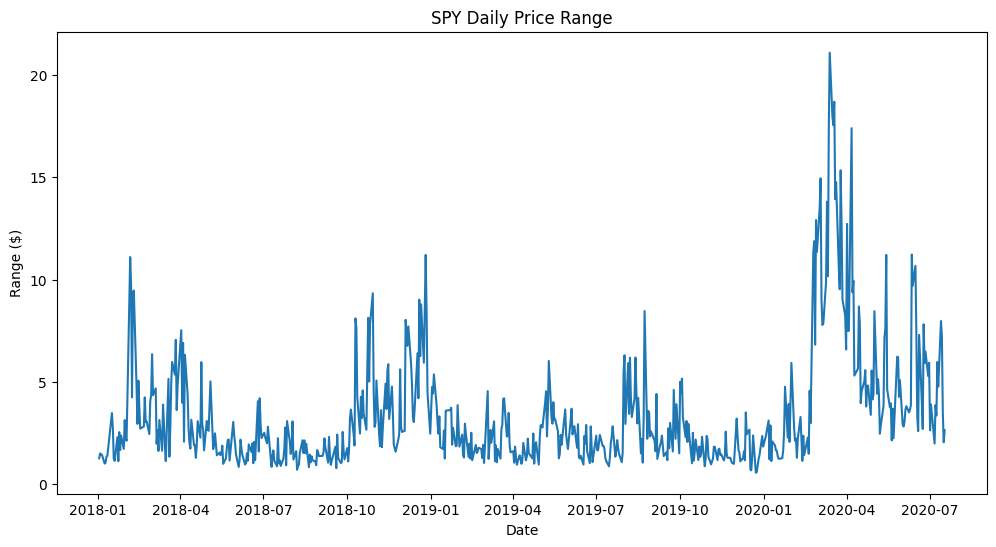

In [117]:
data['Daily_Range'] = data['High'] - data['Low']
plt.figure(figsize=(12, 6))
sns.lineplot(data=data['Daily_Range'])
plt.title('SPY Daily Price Range')
plt.xlabel('Date')
plt.ylabel('Range ($)')
plt.show()

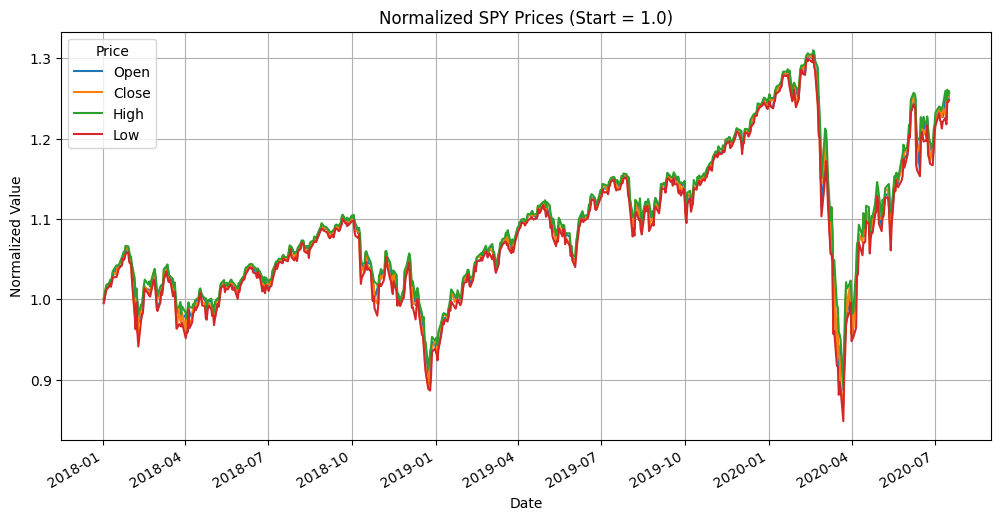

In [118]:
df = data.copy()
df.index = pd.to_datetime(df.index)

# If yfinance returned MultiIndex cols like ('Open','SPY'), flatten to just 'Open'
if isinstance(df.columns, pd.MultiIndex):
    # keep only the first level names: Open, High, Low, Close, Volume
    df.columns = df.columns.get_level_values(0)

normalized = df[['Open', 'Close', 'High', 'Low']] / df['Close'].iloc[0]

ax = normalized.plot(figsize=(12, 6))
ax.set_title('Normalized SPY Prices (Start = 1.0)')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Value')
ax.grid(True)


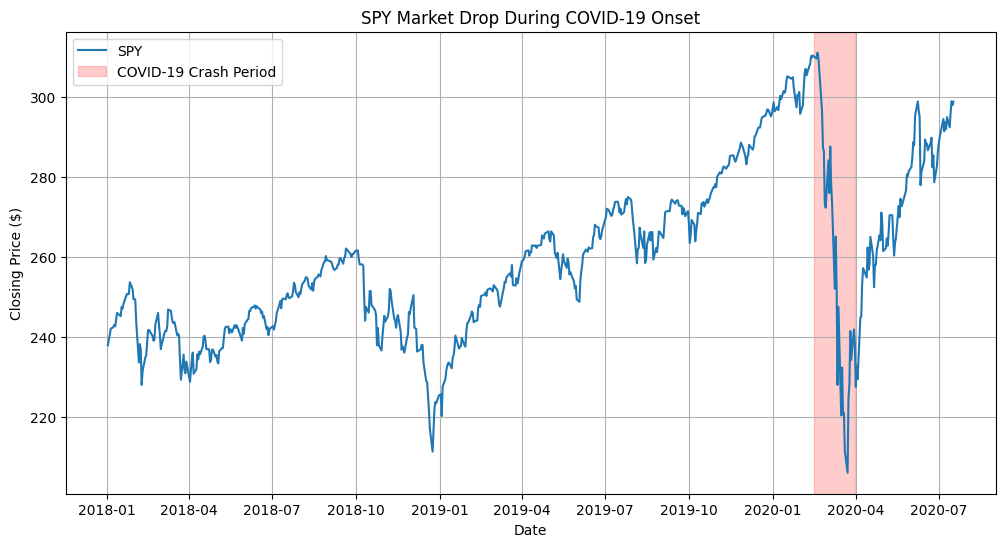

In [119]:
plt.figure(figsize=(12,6))
sns.lineplot(x=data.index, y=data['Close'], label='SPY')
plt.axvspan(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-03-31'),
            color='red', alpha=0.2, label='COVID-19 Crash Period')
plt.title('SPY Market Drop During COVID-19 Onset')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()

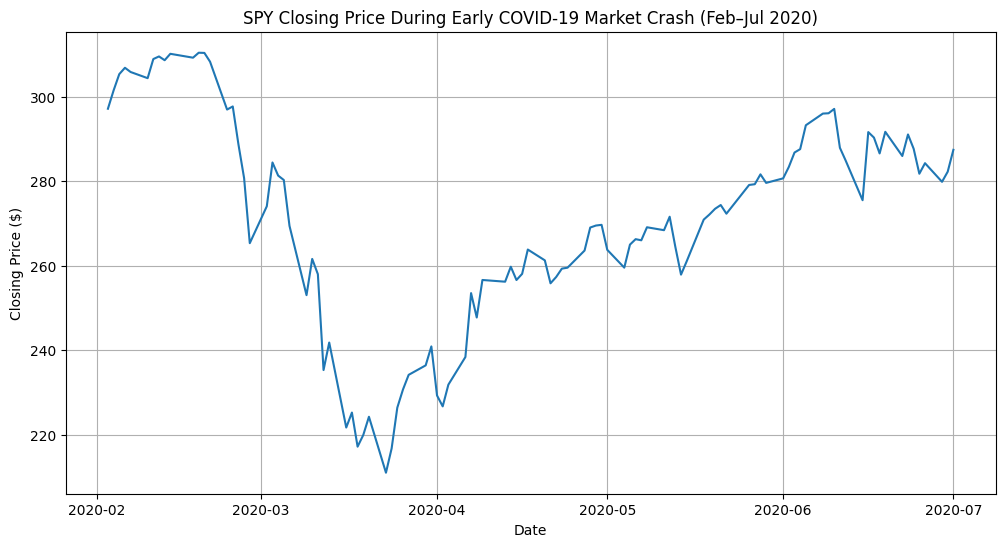

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter roughly February to July 2020
covid_start = "2020-02-01"
covid_end   = "2020-07-01"
covid_data = data.loc[covid_start:covid_end]

plt.figure(figsize=(12,6))
sns.lineplot(x=covid_data.index, y=covid_data['Open'])
plt.title('SPY Closing Price During Early COVID-19 Market Crash (Feb–Jul 2020)')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

feature engineer lagged times

In [121]:
data['Daily_Return'] = data['Close'].pct_change()
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Daily_Range'] = data['High'] - data['Low']

Lagging

In [122]:
lag_days = [2, 7, 14, 30]
for lag in lag_days:
    data[f'Return_Lag_{lag}']     = data['Daily_Return'].shift(lag)
    data[f'LogReturn_Lag_{lag}']  = data['Log_Return'].shift(lag)
    data[f'Range_Lag_{lag}']      = data['Daily_Range'].shift(lag)
data = data.reset_index()
cols_to_show = ['Date', 'Close', 'Daily_Return'] + [f'Return_Lag_{i}' for i in [2, 7, 14, 30]]
data[cols_to_show].head(10)

Price,Date,Close,Daily_Return,Return_Lag_2,Return_Lag_7,Return_Lag_14,Return_Lag_30
0,2018-01-02,237.909164,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,239.413971,0.006325,NaN,NaN,NaN,NaN
2,2018-01-04,240.423080,0.004215,NaN,NaN,NaN,NaN
3,2018-01-05,242.025238,0.006664,0.006325,NaN,NaN,NaN
4,2018-01-08,242.467789,0.001829,0.004215,NaN,NaN,NaN
5,2018-01-09,243.016632,0.002264,0.006664,NaN,NaN,NaN
6,2018-01-10,242.644913,-0.001530,0.001829,NaN,NaN,NaN
7,2018-01-11,244.415161,0.007296,0.002264,NaN,NaN,NaN
8,2018-01-12,246.008575,0.006519,-0.001530,0.006325,NaN,NaN
9,2018-01-16,245.167603,-0.003418,0.007296,0.004215,NaN,NaN


rolling averages

In [123]:
windows = [5, 10, 21]
for w in windows:
    # shift to avoid data leakage
    data[f'Return_RollMean_{w}'] = data['Daily_Return'].shift(1).rolling(w).mean()
    data[f'Return_RollStd_{w}']  = data['Daily_Return'].shift(1).rolling(w).std()
    data[f'Range_RollMean_{w}']  = data['Daily_Range'].shift(1).rolling(w).mean()
data.head()

Price,Date,Close,High,Low,Open,Volume,Daily_Range,Daily_Return,Log_Return,Return_Lag_2,...,Range_Lag_30,Return_RollMean_5,Return_RollStd_5,Range_RollMean_5,Return_RollMean_10,Return_RollStd_10,Range_RollMean_10,Return_RollMean_21,Return_RollStd_21,Range_RollMean_21
0,2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700,1.248104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,239.413971,239.564463,238.077344,238.077344,90070400,1.487119,0.006325,0.006305,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,240.423080,240.909944,239.475961,240.060181,80636400,1.433983,0.004215,0.004206,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000,1.425123,0.006664,0.006642,0.006325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,242.467789,242.627114,241.635720,241.927816,57319200,0.991394,0.001829,0.001827,0.004215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
print(data.isnull().sum().sort_values(ascending=False).head(10))
data = data.dropna().reset_index(drop=True)
print(f"After dropping NaNs: {data.shape[0]} rows remain.")

Price
Return_Lag_30         31
LogReturn_Lag_30      31
Range_Lag_30          30
Return_RollStd_21     22
Return_RollMean_21    22
Range_RollMean_21     21
Return_Lag_14         15
LogReturn_Lag_14      15
Range_Lag_14          14
Return_RollStd_10     11
dtype: int64
After dropping NaNs: 609 rows remain.


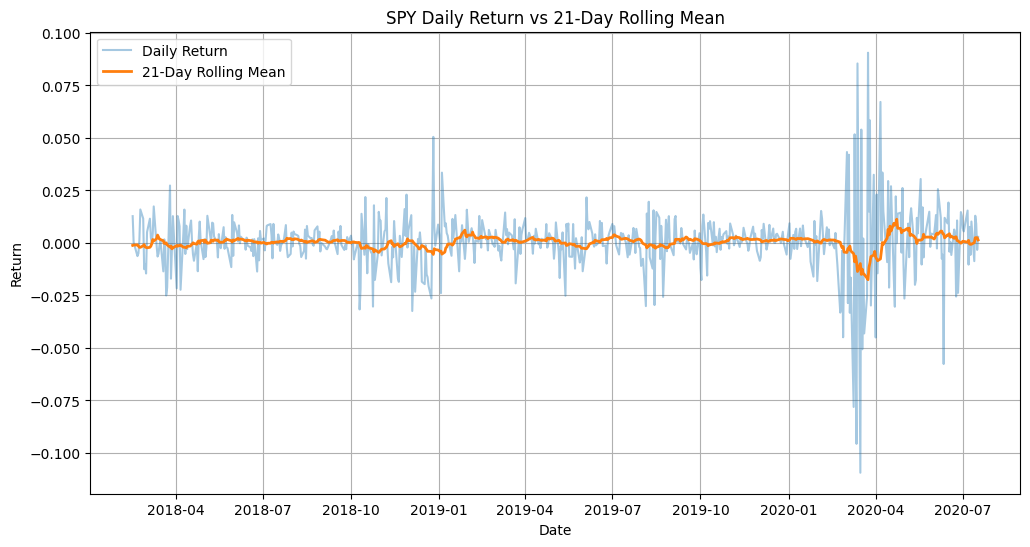

In [126]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Daily_Return'], label='Daily Return', alpha=0.4)
plt.plot(data['Date'], data['Return_RollMean_21'], label='21-Day Rolling Mean', linewidth=2)
plt.title('SPY Daily Return vs 21-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

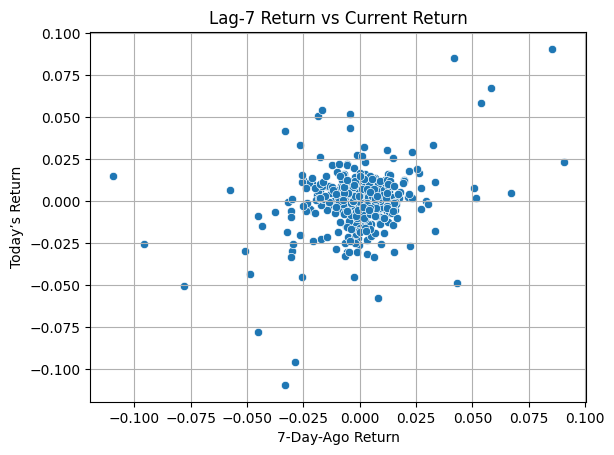

In [127]:
sns.scatterplot(x=data['Return_Lag_7'], y=data['Daily_Return'])
plt.title('Lag-7 Return vs Current Return')
plt.xlabel('7-Day-Ago Return')
plt.ylabel('Today’s Return')
plt.grid(True)
plt.show()

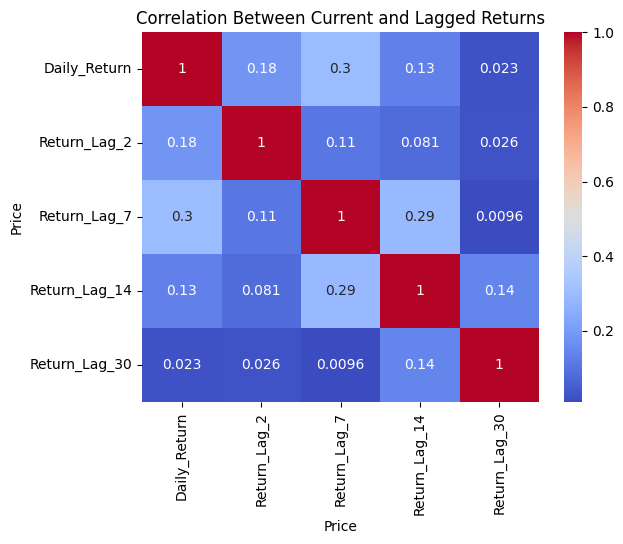

In [128]:
lag_cols = [f'Return_Lag_{i}' for i in [2,7,14,30]]
sns.heatmap(data[['Daily_Return'] + lag_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Current and Lagged Returns')
plt.show()

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("notlucasp/financial-news-headlines")

100%|██████████| 3.91M/3.91M [00:00<00:00, 157MB/s]

Extracting files...


In [ ]:
cnbc = pd.read_csv(path + "/cnbc_headlines.csv")
guardian = pd.read_csv(path + "/guardian_headlines.csv")
reuters = pd.read_csv(path + "/reuters_headlines.csv")

# convert to dataframes
cnbc_df = pd.DataFrame(cnbc)
guardian_df = pd.DataFrame(guardian)
reuters_df = pd.DataFrame(reuters)

## Combine news data

### Subtask:
Merge the three news datasets (CNBC, Guardian, Reuters) into a single DataFrame.


**Reasoning**:
Concatenate the three news dataframes into a single dataframe and display the head of the combined dataframe.



In [ ]:
all_news_df = pd.concat([cnbc_df, guardian_df, reuters_df], ignore_index=True)
display(all_news_df.head())

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


## Clean and preprocess news data

### Subtask:
Handle missing values and potentially clean the text data (e.g., remove punctuation, convert to lowercase).


**Reasoning**:
Check for missing values in the `all_news_df` DataFrame and print the count of missing values per column.



In [ ]:
print("Missing values per column in all_news_df:")
print(all_news_df.isnull().sum())

Missing values per column in all_news_df:
Headlines        280
Time             280
Description    18080
dtype: int64


**Reasoning**:
Drop rows where the 'Headlines' column is missing, as headlines are essential for the analysis, then fill any remaining missing values in other columns (like 'Description') with an empty string to ensure consistency and prevent errors during text processing, and finally convert the 'Headlines' column to lowercase to standardize the text for future analysis.



In [ ]:
all_news_df.dropna(subset=['Headlines'], inplace=True)
all_news_df.fillna('', inplace=True)
all_news_df['Headlines'] = all_news_df['Headlines'].str.lower()
print("Missing values per column after cleaning:")
print(all_news_df.isnull().sum())
display(all_news_df.head())

Missing values per column after cleaning:
Headlines      0
Time           0
Description    0
dtype: int64


,Headlines,Time,Description
0,jim cramer: a better way to invest in the covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,cramer's lightning round: i would own teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
3,"cramer's week ahead: big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,iq capital ceo keith bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."
5,wall street delivered the 'kind of pullback i'...,"7:36 PM ET Thu, 16 July 2020","""Look for the stocks of high-quality companies..."


## Extract date from news data

### Subtask:
Convert the 'Time' column in the news DataFrame to a datetime format and extract only the date.


**Reasoning**:
Convert the 'Time' column to datetime objects, extract the date, and display the first few rows to verify the changes.



In [50]:
all_news_df['Time'] = pd.to_datetime(all_news_df['Time'], infer_datetime_format=True, errors='coerce')
all_news_df['Date'] = all_news_df['Time'].dt.date
display(all_news_df.head())

NameError: name 'all_news_df' is not defined

## EDA: Looking into Covid announcement headlines

In [ ]:
covid_news = all_news_df[
    (all_news_df['Time'] >= '2020-03-15') &
    (all_news_df['Time'] <= '2020-04-18')
].copy()  # good practice: copy filtered slice

covid_news.sort_values(by='Time', inplace=True)
covid_news.reset_index(drop=True, inplace=True)
covid_news

,Headlines,Time,Description,Date
0,american airlines cutting international flight...,2020-03-15,American Airlines Inc said Saturday it plans t...,2020-03-15
1,coronavirus-hit aston martin seeks another £20...,2020-03-15,,2020-03-15
2,uk supermarkets struggle to cope with surge in...,2020-03-15,,2020-03-15
3,"company that loaned sarah ferguson £500,000 go...",2020-03-15,,2020-03-15
4,business live stock markets end wild week wit...,2020-03-15,,2020-03-15
...,...,...,...,...
2931,coronavirus set to usher in big changes at u.s...,2020-04-18,The novel coronavirus may do to U.S. office re...,2020-04-18
2932,exclusive: amazon deploys thermal cameras at w...,2020-04-18,Amazon.com Inc has started to use thermal came...,2020-04-18
2933,u.s. banks seek term changes as fed finalizes ...,2020-04-18,U.S. banks are pushing the Federal Reserve to ...,2020-04-18
2934,u.s. judge puts amazon challenge to pentagon j...,2020-04-18,A U.S. judge on Friday put on hold a suit by A...,2020-04-18


## checking volume of news headlines per day

In [ ]:
min_news_count = all_news_df.groupby('Date').count().min()
max_new_count = all_news_df.groupby('Date').count().max()

min_news_count, max_new_count

(Headlines      1
 Time           1
 Description    1
 dtype: int64,
 Headlines      170
 Time           170
 Description    170
 dtype: int64)

There's up to 170 news headlines that can occur in one day. This is interesting because how we handle these headlines, aggregating before/after running the FINBERT or other sentiment models can play a huge role in the analysis.

## Aggregate news headlines by date

### Subtask:
Group the news headlines by date and combine the headlines for each day into a single entry.


**Reasoning**:
Group the DataFrame by date and aggregate the headlines for each day.



In [ ]:
daily_news_headlines = all_news_df.groupby('Date')['Headlines'].agg(' '.join).reset_index()
display(daily_news_headlines.head())

,Date,Headlines
0,2017-12-17,peter preston on press and broadcasting \n\n\...
1,2017-12-18,france saves marquis de sade’s 120 days of sod...
2,2017-12-19,house prices to fall in london and south-east ...
3,2017-12-20,hedge funds fail to stop 'billion-dollar brain...
4,2017-12-21,guardian brexit watch \n\n\n brexit helped p...


## Merge news and stock data

### Subtask:
Merge the aggregated news DataFrame with the stock price DataFrame based on the date.


In [ ]:
# Reset the index of the 'data' DataFrame to make 'Date' a column
data_reset = data.reset_index()

# Rename the columns to have a single level
data_reset.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_reset.columns.values]

# Rename the 'Date' column from the stock data for clarity
data_reset.rename(columns={'Date_': 'Date_Stock'}, inplace=True)

# Convert the 'Date' column in daily_news_headlines to datetime objects
daily_news_headlines['Date'] = pd.to_datetime(daily_news_headlines['Date'])

# Shift the news dates forward by one day to align with the next day's stock price movement
daily_news_headlines['Date_Shifted'] = daily_news_headlines['Date'] + pd.Timedelta(days=1)

# Merge the stock price data and the aggregated news headlines based on the shifted news date and stock date
merged_data = pd.merge(data_reset, daily_news_headlines, left_on='Date_Stock', right_on='Date_Shifted', how='left')
print(merged_data.head())

# Drop the original 'Date' and 'Date_Shifted' columns from the merged_data as they are no longer needed for direct use
merged_data.drop(columns=['Date', 'Date_Shifted'], inplace=True)

# Display the head of the merged DataFrame
display(merged_data.head())

  Date_Stock   Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY  \
0 2018-01-02  237.909134  237.944549  236.696445  237.085925    86655700   
1 2018-01-03  239.413956  239.564448  238.077329  238.077329    90070400   
2 2018-01-04  240.423050  240.909914  239.475931  240.060151    80636400   
3 2018-01-05  242.025314  242.149225  240.724102  241.219799    83524000   
4 2018-01-08  242.467819  242.627145  241.635750  241.927847    57319200   

        Date                                          Headlines Date_Shifted  
0        NaT                                                NaN          NaT  
1 2018-01-02  cramer remix: my prediction for apple in 2018 ...   2018-01-03  
2 2018-01-03  cramer remix: i've issued more mea culpas on g...   2018-01-04  
3 2018-01-04  cramer remix: even at dow 25k, this market is ...   2018-01-05  
4        NaT                                                NaN          NaT  


,Date_Stock,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Headlines
0,2018-01-02,237.909134,237.944549,236.696445,237.085925,86655700,NaN
1,2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400,cramer remix: my prediction for apple in 2018 ...
2,2018-01-04,240.423050,240.909914,239.475931,240.060151,80636400,cramer remix: i've issued more mea culpas on g...
3,2018-01-05,242.025314,242.149225,240.724102,241.219799,83524000,"cramer remix: even at dow 25k, this market is ..."
4,2018-01-08,242.467819,242.627145,241.635750,241.927847,57319200,NaN


In [ ]:
# Check for missing values in the 'Headlines' column after merging
print("Missing values in 'Headlines' after merging and shifting:")
print(merged_data['Headlines'].isnull().sum())

# Drop rows where 'Headlines' is NaN
merged_data.dropna(subset=['Headlines'], inplace=True)

print("\nMissing values in 'Headlines' after dropping rows:")
print(merged_data['Headlines'].isnull().sum())

display(merged_data.head())

Missing values in 'Headlines' after merging and shifting:
0

Missing values in 'Headlines' after dropping rows:
0


,Date_Stock,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Headlines
1,2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400,cramer remix: my prediction for apple in 2018 ...
2,2018-01-04,240.423050,240.909914,239.475931,240.060151,80636400,cramer remix: i've issued more mea culpas on g...
3,2018-01-05,242.025314,242.149225,240.724102,241.219799,83524000,"cramer remix: even at dow 25k, this market is ..."
5,2018-01-09,243.016556,243.645024,242.609355,242.892618,57254000,cramer remix: tesla’s stock is up for one simp...
6,2018-01-10,242.644791,242.910360,241.582594,242.255310,69574300,three rate hikes by the fed in 2018 would be p...
